# Development - Bug 01

Projection for W4750 looks incorrect. Needs investigation.

# Package Imports

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

import sys
sys.path.append("..")

In [2]:
import thor

thor.setupOorb()
config = thor.Config()

In [3]:
DATABASE = "../data/msst_survey.db"
con = sql.connect(DATABASE)

## Config

In [4]:
from thor import Config

## Plotting Code

In [5]:
from thor.plotting import plotProjections
from thor.plotting import plotProjections3D
from thor.plotting import plotObservations
from thor.plotting import plotObservations3D
from thor.plotting import plotBinnedContour
from thor.plotting import plotScatterContour
from thor.plotting import plotCell

## Classes 

In [6]:
from thor import Cell
from thor import TestParticle

## Functions

In [7]:
from thor import findAverageObject
from thor import findExposureTimes
from thor import buildCellForVisit
from thor import rangeAndShift
from thor import clusterAndLink
from thor import analyzeClusters

# Load Data

In [8]:
observationsNoNoise = pd.read_sql("""SELECT * FROM observations""", con)
noise = pd.read_sql("""SELECT * FROM noise_100""", con)
noise["obsId"] = np.arange(observationsNoNoise["obsId"].values[-1] + 1, observationsNoNoise["obsId"].values[-1] + 1 + len(noise))

In [9]:
observations = pd.concat([observationsNoNoise, noise], sort=False)
observations.reset_index(inplace=True, drop=True)
del observationsNoNoise
del noise

In [10]:
survey = pd.read_sql("""SELECT * FROM survey""", con)

In [11]:
orbits = pd.read_sql("""SELECT * FROM mpcOrbitCat""", con)

In [12]:
objects = observations[observations[Config.columnMapping["name"]] != "NS"]

In [13]:
import time 
def runThorOnVisit(observations,
                      visitId,
                      r, 
                      v,
                      searchArea=0.3, 
                      searchShape="square",
                      cellArea=0.3, 
                      cellShape="square",
                      useAverageObject=True,
                      verbose=True,
                      columnMapping=True):
    """
    
    Parameters
    ----------
    observations : 
    v
    """
    
    if verbose == True:
        print("THOR: runThorOnVisit")
        print("-------------------------")
        print("Running Thor on visit {}...".format(visitId))
        if useAverageObject != True:
            print("Assuming orbit with r = {}".format(r))
            print("Assuming orbit with v = {}".format(v))
        else:
            print("Search cell area: {} ".format(searchArea))
            print("Search cell shape: {} ".format(searchShape))
      
            
        print("Cell area: {} ".format(cellArea))
        print("Cell shape: {} ".format(cellShape))
        print("")
    time_start = time.time()

    if useAverageObject is True:
        small_cell = buildCellForVisit(observations, visitId, area=searchArea, shape=searchShape)
        small_cell.getObservations()
        avg_obj = findAverageObject(small_cell.observations)
        if avg_obj == -1:
            print("Can't run RaSCaLS on this visit.")
            print("Provide an orbit to run.")
            return

        obj = small_cell.observations[small_cell.observations[config.columnMapping["name"]] == avg_obj]
        r = obj[config.columnMapping["r_au"]].values[0]
        v = obj[[config.columnMapping["obj_dx/dt_au_p_day"], 
                 config.columnMapping["obj_dy/dt_au_p_day"],
                 config.columnMapping["obj_dz/dt_au_p_day"]]].values[0]

    cell = Cell(small_cell.center, small_cell.mjd, observations, area=cellArea, shape=cellShape)
    projected_obs = rangeAndShift(observations, cell, r, v)
    
    if useAverageObject == True:
        return projected_obs, avg_obj
    else:
        return project_obs

In [37]:
projected_obs, avg_obj = runThorOnVisit(observations, 1, 0, 0, searchArea=0.1, cellArea=0.1)

THOR: runThorOnVisit
-------------------------
Running Thor on visit 1...
Search cell area: 0.1 
Search cell shape: square 
Cell area: 0.1 
Cell shape: square 

THOR: findAverageObject
-------------------------
58907 is the most average object.
-------------------------

THOR: rangeAndShift
-------------------------
Running range and shift...
Assuming r = 3.1319824347000003 AU
Assuming v = [-0.00797112 -0.00360525  0.0001833 ] AU per day
Preparing rotation matrices...
Convering to ecliptic coordinates...
Calculating object to observer unit vector...
Calculating object to observer distance assuming r = 3.1319824347000003 AU...
Calculating object to observer position vector...
Calculating barycentic object position vector...
Calculating vector normal to plane of orbit...
Calculating R1 rotation matrix...
Calculating R2 rotation matrix...
Calculating final rotation matrix...
Done.

THOR: findExposureTimes
-------------------------
Generating particle ephemeris for the middle of every nigh

In [45]:
obj = projected_obs[projected_obs["designation"] == "W4750"]

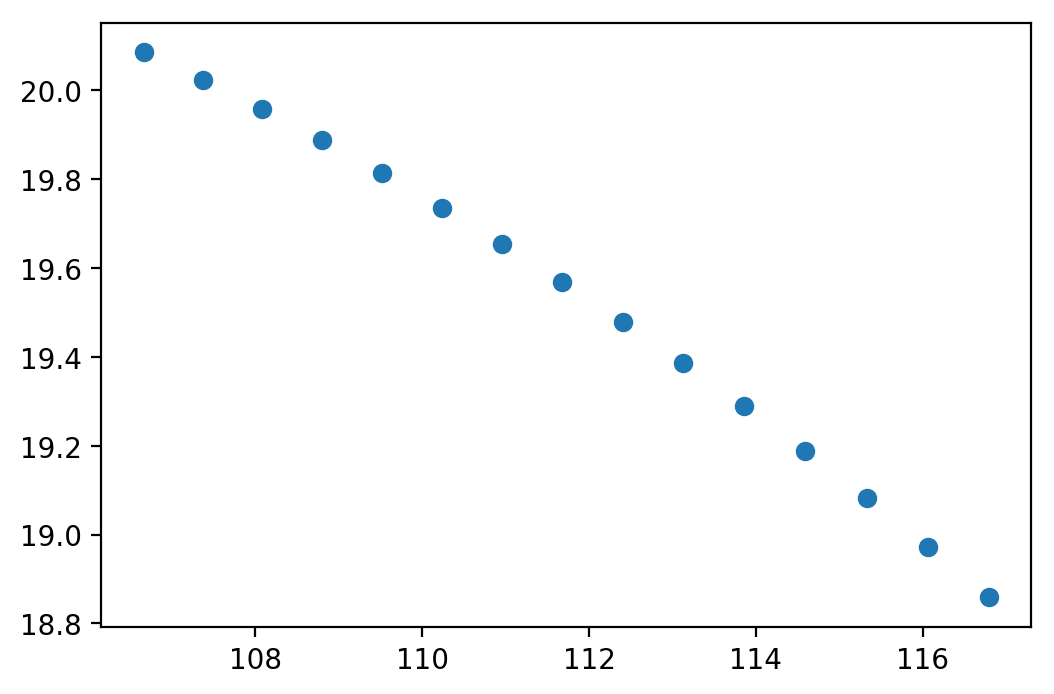

In [46]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(*obj[Config.radec].values.T)


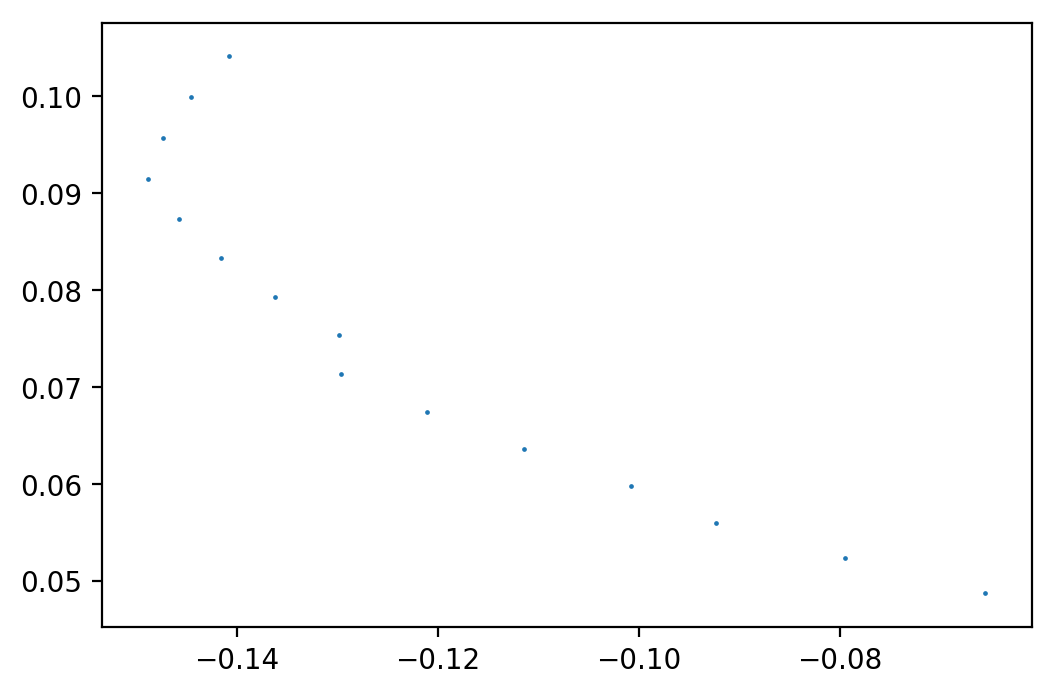

In [47]:
fig, ax = plt.subplots(1, 1, dpi=200)

ax.scatter(*obj[["theta_x_deg", "theta_y_deg"]].values.T, s=0.5)

In [48]:
fig = plotProjections(obj, colorByObject=True)

In [41]:
allClusters, clusterMembers = clusterAndLink(projected_obs, eps=0.1, minSamples=5, vxRange=[-.1, .1], vyRange=[-.1, .1], vxNum=100, vyNum=100, threads=1)

THOR: clusterAndLink
-------------------------
Running velocity space clustering...
X velocity range: [-0.1, 0.1]
X velocity bins: 100
Y velocity range: [-0.1, 0.1]
Y velocity bins: 100
Max sample distance: 0.1
Minimum samples: 5
Done. Completed in 18.166258811950684 seconds.

Restructuring clusters...
Done. Completed in 249.00692415237427 seconds.

Found 12879 clusters.
Total time in seconds: 267.17331409454346
-------------------------



In [42]:
allClusters, clusterMember, allObjects = analyzeClusters(projected_obs, allClusters, clusterMembers, partialThreshold=1.0, minSamples=5)

THOR: analyzeClusters
-------------------------
Analyzing observations...
Object observations: 276
Noise observations: 117
Observation contamination (%): 29.770992366412212
Unique objects: 147
Unique objects with at least 5 detections: 5
Unique objects with at least 100.0% of 5 detections: 5

Analyzing clusters...
Pure clusters: 0
Partial clusters: 0
False clusters: 12879
Total clusters: 12879
Cluster contamination (%): 100.0
Unique linked objects: 0
Unique missed objects: 5
Completeness (%): 0.0
Done.
Total time in seconds: 1.9219319820404053
-------------------------



In [49]:
obj

obsId  visitId  fieldId  fieldRA_deg  fieldDec_deg       exp_mjd  \
811          812        1        1   106.712809     20.041638  59739.937500   
322695    322696     1201        1   106.712809     20.041638  59741.937500   
647531    647532     2401        1   106.712809     20.041638  59743.937500   
980636    980637     3640       40   109.875087     20.041638  59745.964583   
1311402  1311403     4840       40   109.875087     20.041638  59747.964583   
1645144  1645145     6040       40   109.875087     20.041638  59749.964583   
1981944  1981945     7240       40   109.875087     20.041638  59751.964583   
2324026  2324027     8441       41   113.037364     20.041638  59753.965278   
2667232  2667233     9641       41   113.037364     20.041638  59755.965278   
3013541  3013542    10841       41   113.037364     20.041638  59757.965278   
3363352  3363353    12041       41   113.037364     20.041638  59759.965278   
3716270  3716271    13241       41   113.037364     20.041638  59761.965278   
4079155  4079156    14480       80   116.199642     20.041638  59763.992361   
4438783  4438784    15680       80   116.199642     20.041638  59765.992361   
4801578  4801579    16880       80   116.199642     20.041638  59767.992361   

         night designation code       mjd_utc       ...        HEclObsy_X_au  \
811      59740       W4750  I11  59739.937500       ...            -0.197823   
322695   59742       W4750  I11  59741.937500       ...            -0.164536   
647531   59744       W4750  I11  59743.937500       ...            -0.131069   
980636   59746       W4750  I11  59745.964583       ...            -0.096999   
1311402  59748       W4750  I11  59747.964583       ...            -0.063272   
1645144  59750       W4750  I11  59749.964583       ...            -0.029469   
1981944  59752       W4750  I11  59751.964583       ...             0.004375   
2324026  59754       W4750  I11  59753.965278       ...             0.038231   
2667232  59756       W4750  I11  59755.965278       ...             0.072038   
3013541  59758       W4750  I11  59757.965278       ...             0.105767   
3363352  59760       W4750  I11  59759.965278       ...             0.139377   
3716270  59762       W4750  I11  59761.965278       ...             0.172828   
4079155  59764       W4750  I11  59763.992361       ...             0.206532   
4438783  59766       W4750  I11  59765.992361       ...             0.239544   
4801578  59768       W4750  I11  59767.992361       ...             0.272280   

         HEclObsy_Y_au  HEclObsy_Z_au     EccAnom    TrueAnom  PosAngle_deg  \
811          -0.995696       0.000026  252.328509  244.037096     95.367882   
322695       -1.001956       0.000028  252.671365  244.360753     95.675409   
647531       -1.007089       0.000030  253.014511  244.684957     95.981243   
980636       -1.011143       0.000034  253.362601  245.014114     96.292386   
1311402      -1.013995       0.000035  253.706335  245.339431     96.593908   
1645144      -1.015707       0.000035  254.050363  245.665304     96.894272   
1981944      -1.016275       0.000035  254.394687  245.991737     97.193597   
2324026      -1.015697       0.000034  254.739426  246.318845     97.491850   
2667232      -1.013969       0.000033  255.084343  246.646406     97.788948   
3013541      -1.011094       0.000032  255.429560  246.974534     98.084764   
3363352      -1.007074       0.000032  255.775076  247.303233     98.379135   
3716270      -1.001915       0.000031  256.120894  247.632507     98.671874   
4079155      -0.995535       0.000034  256.471704  247.966827     98.953858   
4438783      -0.988103       0.000034  256.818133  248.297264     99.241698   
4801578      -0.979559       0.000035  257.164867  248.628284     99.527311   

         theta_x_deg  theta_y_deg  theta_x_eq_deg  theta_y_eq_deg  
811        -0.065501     0.048671       -0.048620       86.622551  
322695     -0.079454     0.052295       -0.059284        0.04814

In [ ]:
def plotProjections3D(dataframe, 
                  colorByObject=False, 
                  columnMapping=Config.columnMapping):
    """
    Plot projected observations in 3D. 
    
    Parameters
    ----------
    dataframe : `~pandas.DataFrame`
        DataFrame containing relevant quantities to be plotted.
    colorByObject : bool, optional
        Color each unique object separately. 
        [Default = False]
    columnMapping : dict, optional
        Column name mapping of observations to internally used column names. 
        [Default = `~thor.Config.columnMapping`]
   
    Returns
    -------
    fig : `~plotly.figure`
        Returns the plotly figure object.

    """
    data = []
    if colorByObject is True:
        for name in dataframe[columnMapping["name"]].unique():
            obj = dataframe[dataframe[columnMapping["name"]] == name]

            if name == "NS":
                 trace = plotly.graph_objs.Scatter3d(
                    x=obj["theta_x_deg"],
                    y=obj["theta_y_deg"],
                    z=obj[columnMapping["exp_mjd"]] - dataframe[columnMapping["exp_mjd"]].min(),
                    name=name,
                    mode="markers",
                    marker=dict(size=2)
                )
            else:
                trace = plotly.graph_objs.Scatter3d(
                    x=obj["theta_x_deg"],
                    y=obj["theta_y_deg"],
                    z=obj[columnMapping["exp_mjd"]] - dataframe[columnMapping["exp_mjd"]].min(),
                    name=name,
                    mode="lines+markers",
                    marker=dict(size=2,
                                line=dict(width=4))
                )
            data.append(trace)
    else:
        trace = plotly.graph_objs.Scatter3d(
            x=dataframe["theta_x_deg"],
            y=dataframe["theta_y_deg"],
            z=dataframe[columnMapping["exp_mjd"]] - dataframe[columnMapping["exp_mjd"]].min(),
            mode="markers",
            marker=dict(size=2)
            )
        data.append(trace)

    layout = dict(
        width=800,
        height=550,
        autosize=False,
        title="",
        scene=dict(
            xaxis=dict(
                title="Theta X [deg]",
            ),
            yaxis=dict(
                title="Theta Y [deg]",
            ),
            zaxis=dict(
                title="Days [MJD]",
            ),
            aspectratio = dict(x=1, y=1, z=1)))

    fig = plotly.graph_objs.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig)
    return fig
    

In [57]:
dataframe = obj
columnMapping = Config.columnMapping
data = []
trace = plotly.graph_objs.Scatter3d(
            x=dataframe[columnMapping["obj_x_au"]],
            y=dataframe[columnMapping["obj_y_au"]],
            z=dataframe[columnMapping["obj_z_au"]],
            mode="markers",
            marker=dict(size=2)
            )

data.append(trace)

trace = plotly.graph_objs.Scatter3d(
            x=dataframe[columnMapping["obs_x_au"]],
            y=dataframe[columnMapping["obs_y_au"]],
            z=dataframe[columnMapping["obs_z_au"]],
            mode="markers",
            marker=dict(size=2)
            )
data.append(trace)

layout = dict(
    width=800,
    height=550,
    autosize=False,
    title="",
    scene=dict(
        xaxis=dict(
            title="Theta X [deg]",
        ),
        yaxis=dict(
            title="Theta Y [deg]",
        ),
        zaxis=dict(
            title="Days [MJD]",
        ),
        aspectratio = dict(x=1, y=1, z=1)))

fig = plotly.graph_objs.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [58]:
dataframe = obj
columnMapping = Config.columnMapping
data = []
trace = plotly.graph_objs.Scatter3d(
            x=dataframe[columnMapping["obj_x_au"]],
            y=dataframe[columnMapping["obj_y_au"]],
            z=dataframe[columnMapping["obj_z_au"]],
            mode="markers",
            marker=dict(size=2)
            )

#data.append(trace)

trace = plotly.graph_objs.Scatter3d(
            x=dataframe[columnMapping["obs_x_au"]],
            y=dataframe[columnMapping["obs_y_au"]],
            z=dataframe[columnMapping["obs_z_au"]],
            mode="markers",
            marker=dict(size=2)
            )
data.append(trace)

layout = dict(
    width=800,
    height=550,
    autosize=False,
    title="",
    scene=dict(
        xaxis=dict(
            title="Theta X [deg]",
        ),
        yaxis=dict(
            title="Theta Y [deg]",
        ),
        zaxis=dict(
            title="Days [MJD]",
        ),
        aspectratio = dict(x=1, y=1, z=1)))

fig = plotly.graph_objs.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [61]:
dataframe=survey

trace = plotly.graph_objs.Scatter3d(
            x=dataframe[columnMapping["obs_x_au"]],
            y=dataframe[columnMapping["obs_y_au"]],
            z=dataframe[columnMapping["obs_z_au"]],
            mode="markers",
            marker=dict(size=2)
            )
data.append(trace)

layout = dict(
    width=800,
    height=550,
    autosize=False,
    title="",
    scene=dict(
        xaxis=dict(
            title="X [AU]",
        ),
        yaxis=dict(
            title="Y [AU]",
        ),
        zaxis=dict(
            title="Z [AU]",
        ),
        aspectratio = dict(x=1, y=1, z=1)))

fig = plotly.graph_objs.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)